In [1]:
import polars as pl
import polars.selectors as cs


import seaborn as sns


import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

data_folder_path = Path().resolve().parent / "__temp_bots_Jun10_16h04m02.8s"
data_folder_path = Path().resolve().parent / "__temp_bots_Jun10_16h17m40.0s"
data_folder_path = Path().resolve().parent / "__temp_bots_Jun10_17h08m28.6s"

app_name = "network_pd.csv"

In [3]:
raw_df = pl.read_csv(data_folder_path / app_name)
df = raw_df.with_columns(
    pl.col("player.action")
    .shift(1)
    .over(pl.col("participant.code"))
    .alias("next_action"),
).sort("participant.code")


df.select("player.action", "next_action").to_pandas()

,player.action,next_action
0,1,NaN
1,1,1.0
2,0,1.0
3,0,0.0
4,1,0.0
...,...,...
5395,1,1.0
5396,0,1.0
5397,0,0.0
5398,0,0.0


In [4]:
df.columns

['participant.id_in_session',
 'participant.code',
 'participant.label',
 'participant._is_bot',
 'participant._index_in_pages',
 'participant._max_page_index',
 'participant._current_app_name',
 'participant._current_page_name',
 'participant.time_started_utc',
 'participant.visited',
 'participant.mturk_worker_id',
 'participant.mturk_assignment_id',
 'participant.payoff',
 'player.id_in_group',
 'player.role',
 'player.payoff',
 'player.action',
 'player.confirm_results',
 'player.time_out',
 'player.current_payoff',
 'player.neighbor_actions',
 'player.neighbor_coop_ratio',
 'player.neighbor_payoffs',
 'player.highest_action',
 'player.show_payoffs',
 'group.id_in_subsession',
 'group.dicision_start_time',
 'group.show_payoffs',
 'subsession.round_number',
 'session.code',
 'session.label',
 'session.mturk_HITId',
 'session.mturk_HITGroupId',
 'session.comment',
 'session.is_demo',
 'next_action']

<Axes: xlabel='sum_payoff', ylabel='Count'>

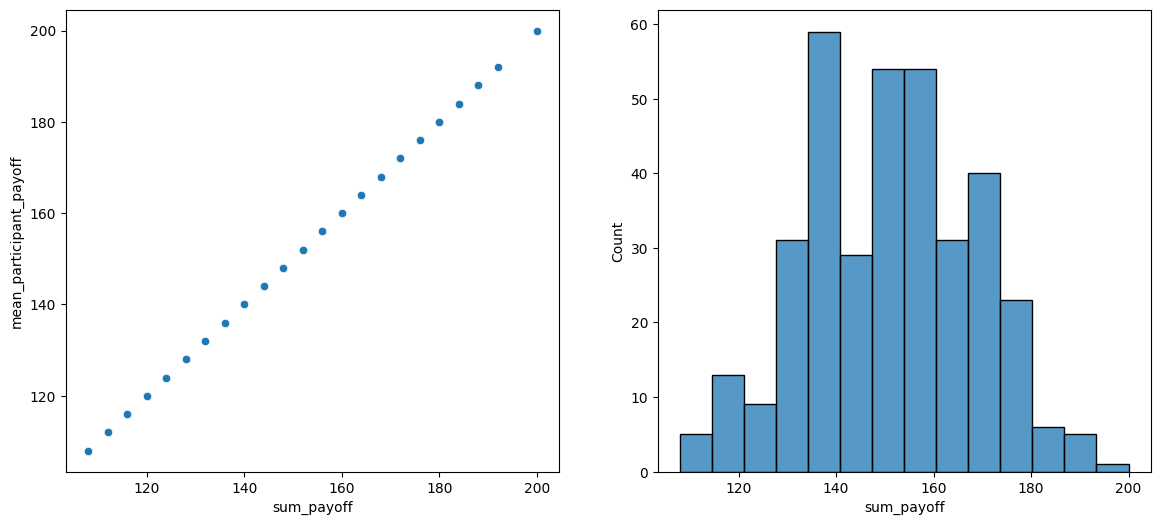

In [5]:
# payoff の計算が大丈夫か確認する
# payoff distribution
plt_df = df.group_by("participant.id_in_session").agg(
    pl.col("player.payoff").sum().alias("sum_payoff"),
    pl.col("participant.payoff").mean().alias("mean_participant_payoff"),
)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(
    data=plt_df.to_pandas(),
    x="sum_payoff",
    y="mean_participant_payoff",
    ax=axes[0],
)

sns.histplot(
    plt_df.to_pandas(),
    x="sum_payoff",
    ax=axes[1],
)

(0.0, 1.0)

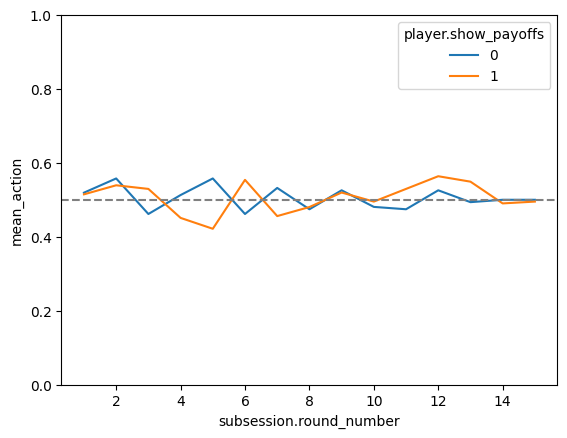

In [6]:
# round ごと，条件別の協力率
plt_df = df.group_by(["player.show_payoffs", "subsession.round_number"]).agg(
    pl.col("player.action").mean().alias("mean_action"),
)
# plt_df.glimpse()
ax = sns.lineplot(
    data=plt_df.to_pandas(),
    x="subsession.round_number",
    y="mean_action",
    hue="player.show_payoffs",
)
ax.axhline(0.5, color="gray", linestyle="--", label="50% Cooperation Rate")
ax.set_ylim(0, 1)

Rows: 5040
Columns: 5
$ player.show_payoffs        <i64> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ player.neighbor_coop_ratio <f64> 0.25, 0.25, 0.5, 0.0, 0.75, 0.5, 0.25, 1.0, 0.5, 0.5
$ player.highest_action      <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ player.action              <i64> 1, 0, 0, 1, 1, 0, 0, 0, 1, 0
$ next_action                <i64> 1, 1, 0, 0, 1, 1, 0, 0, 0, 1

None
shape: (32, 5)
┌─────────────────────┬───────────────────────┬──────────────────────┬─────────────┬───────────────┐
│ player.show_payoffs ┆ player.neighbor_coop_ ┆ player.highest_actio ┆ next_action ┆ player.action │
│ ---                 ┆ ratio                 ┆ n                    ┆ ---         ┆ ---           │
│ i64                 ┆ ---                   ┆ ---                  ┆ i64         ┆ f64           │
│                     ┆ f64                   ┆ i64                  ┆             ┆               │
╞═════════════════════╪═══════════════════════╪══════════════════════╪═════════════╪═══════════════╡
│ 0    

C:\Users\Takahashi\AppData\Local\Temp\ipykernel_32440\1750265519.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Show Payoffs")
C:\Users\Takahashi\AppData\Local\Temp\ipykernel_32440\1750265519.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Show Payoffs")
C:\Users\Takahashi\AppData\Local\Temp\ipykernel_32440\1750265519.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Show Payoffs")
C:\Users\Takahashi\AppData\Local\Temp\ipykernel_32440\1750265519.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start wit

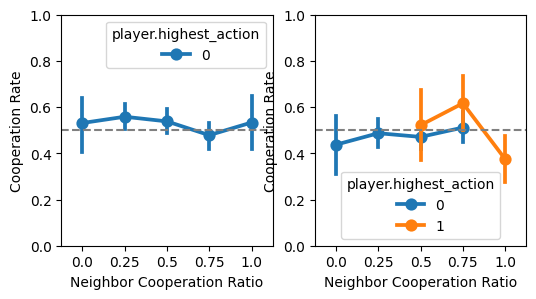

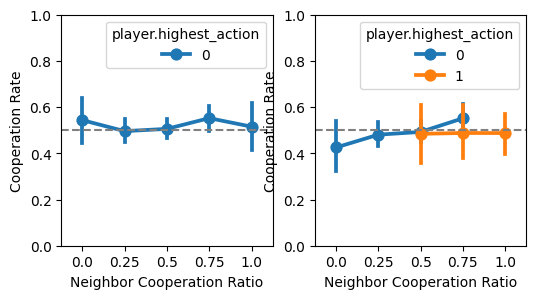

In [7]:
# round ごと，条件別の協力率
plt_df = df.filter(pl.col("subsession.round_number") > 1).select(
    "player.show_payoffs",
    "player.neighbor_coop_ratio",
    "player.highest_action",
    "player.action",
    "next_action",
)
print(plt_df.glimpse())

summary_df = (
    plt_df.group_by(cs.all().exclude("player.action"))
    .agg(
        pl.col("player.action").mean().alias("player.action"),
    )
    .sort("player.neighbor_coop_ratio")
)
print(summary_df)


for show_payoffs in [0, 1]:
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for player_action, ax in enumerate(axes):
        ax.set_xlabel("Neighbor Cooperation Ratio")
        ax.set_ylabel("Cooperation Rate")
        ax.legend(title="Show Payoffs")
        sns.pointplot(
            data=plt_df.filter(pl.col("player.show_payoffs") == show_payoffs)
            .filter(pl.col("player.action") == player_action)
            .to_pandas(),
            x="player.neighbor_coop_ratio",
            # y="mean_action",
            # y="player.action",
            y="next_action",
            hue="player.highest_action",
            ax=ax,
        )
        ax.axhline(0.5, color="gray", linestyle="--", label="50% Cooperation Rate")
        ax.set_ylim(0, 1)

| Action | C=0 | C=1 | C=2 | C=3 | C=4 |
| ------ | --- | --- | --- | --- | --- |
| C      | 0   | 6   | 12  | 18  | 24  |
| D      | 4   | 10  | 16  | 22  | 28  |


| Action | C=0 | C=1         | C=2           | C=3           | C=4           |
| ------ | --- | ----------- | ------------- | ------------- | ------------- |
| C      | 0   | $(b/c)$     | $2 (b/c)$     | $3 (b/c)$     | $4 (b/c)$     |
| D      | 4   | $(b/c) + 4$ | $2 (b/c) + 4$ | $3 (b/c) + 4$ | $4 (b/c) + 4$ |


In [15]:
plt_df = (
    df.filter(pl.col("player.neighbor_coop_ratio").is_between(0.5, 0.75))
    .filter(pl.col("player.action") == 1)
    .filter(pl.col("subsession.round_number") < 15)
)
plt_df.shape

(1580, 36)